#Season 12-15 = 0.0002 - 0.0002*dfc["ballpark_fortification"]
Formula works for every season, but has outliers if the player selected has one of the two Flickering Mods.
Needs further research to only check for Flickering Players

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

In [2]:
all_files = glob.glob("../roll_data/*-fback.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

# seasons = [11, 12]
seasons = [11,12,13,14]
# seasons = [14]
# seasons = [13, 14]
df = df[df['season'].isin(seasons)]
len(df)

65708

In [3]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]


batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']
pitcher_params = ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']
fielder_params = ['fielder_anticapitalism', 'fielder_chasiness', 'fielder_omniscience', 'fielder_tenaciousness', 'fielder_watchfulness']
for attr in batter_params:
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']


dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

dfc = dfc[dfc["batter_multiplier"] == 1]
dfc = dfc[dfc["pitcher_multiplier"] == 1]


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["fort"] = dfc["ballpark_fortification"] - 0.5

X = dfc[["roll", "ballpark_fortification"]]
y = dfc['passed']

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=500000, max_iter=5000000, tol=1e-5).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
confusion_matrix(y,predictionsvm)

array([[53050,     0],
       [    9,     0]], dtype=int64)

In [5]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'), (-0.029629260199288934, 'ballpark_fortification')]

In [6]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([3.4311051])

In [7]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

53050
9


In [9]:
fort = dfc["ballpark_fortification"] - 0.5


#Season 12-15 = 0.0002 - 0.0002*dfc["ballpark_fortification"]
dfc["threshold"] = 0.0002 - 0.0002*dfc["ballpark_fortification"]

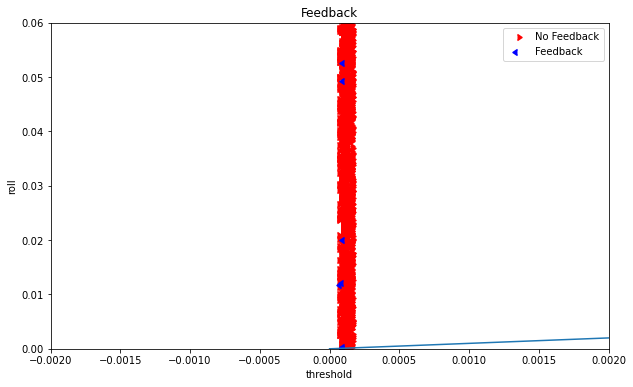

In [10]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="No Feedback", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Feedback", marker=CARETLEFTBASE)

ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Feedback")
ax.set_xlim([-0.002, 0.002])
ax.set_ylim([0.00, 0.06])
ax.legend()

,offset,weather,event_type,fielder_mods,pitcher_overpowerment,roll,threshold,fielder_name,season,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
90,0.000171,Weather.FEEDBACK,Swap,<NA>,0.510311,0.000271,0.000100,<NA>,11,NaN,Montgomery Bullock,FLICKERING;RECEIVER,FRIEND_OF_CROWS;WILD,LOVE,<NA>,30,0d4d3edb-7727-40f4-ab03-617bb2c0f7f4,141
42011,0.011707,Weather.FEEDBACK,Swap,<NA>,0.172319,0.011786,0.000079,<NA>,13,Nicholas Mora,<NA>,<NA>,FLICKERING;RECEIVER;ALTERNATE,FIREPROOF;SEALANT;AMBUSH,<NA>,78,30e0cfa2-091f-4501-8ebb-378650a04392,106
39017,0.011983,Weather.FEEDBACK,Swap,<NA>,0.172319,0.012079,0.000095,<NA>,13,Justice Spoon,<NA>,ALTERNATE;FIRE_EATER,FLICKERING;RECEIVER,<NA>,BOTTOM_DWELLER,66,f814e524-a257-4e72-a0c6-f7dae24aa15e,140
2369,0.019866,Weather.FEEDBACK,Swap,<NA>,0.216309,0.019966,0.000100,<NA>,11,NaN,Patty Fox,FLICKERING;RECEIVER,<NA>,<NA>,BIRD_SEED,49,bc9788bd-7ef9-4ed1-ba33-b29e57380cb6,228
15936,0.049233,Weather.FEEDBACK,Swap,<NA>,0.790761,0.049333,0.000100,<NA>,12,Sparks Beans,Jaylen Hotdogfingers,<NA>,WILD;FRIEND_OF_CROWS;FLIICKERRRIIING;SQUIDDISH,<NA>,MAINTENANCE_MODE,63,a351f1c9-7890-45ce-bb8a-86f4901006e3,74
3707,0.052513,Weather.FEEDBACK,Swap,<NA>,0.790761,0.052613,0.000100,<NA>,11,Juice Collins,Jaylen Hotdogfingers,<NA>,WILD;FRIEND_OF_CROWS;FLIICKERRRIIING;SQUIDDISH,<NA>,O_NO,55,de8676e2-0b77-4a52-9349-928757c24289,12


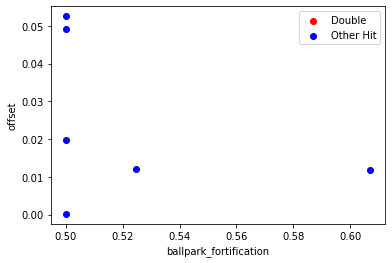

In [11]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "ballpark_fortification"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Double")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Other Hit")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "weather", "event_type", "fielder_mods", "pitcher_overpowerment",
       "roll", "threshold",
       "fielder_name", "season",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


In [265]:
print(dfc[dfc["passed"]]["roll"].min())
print(dfc[~dfc["passed"]]["roll"].max())

0.0002648354734513525
0.9994472809302016
